In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5324.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3382.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1398.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1142.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5002.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2646.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3476.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1613.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5593.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2975.BMP
/kaggle/input/finger-print-based-blood-g

In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
dataset_path="/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group"

In [62]:
BATCH_SIZE=32

In [63]:
#STEP 1: LOAD DATASET
dataset=image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64,64),  # resize images to standard size
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [64]:
# step 2: check class distribution
class_names=dataset.class_names
class_counts=Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())]+=1

print("Class Distribution:")
for i,count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
A+: 565
A-: 1009
O+: 852
AB+: 708
AB-: 761
O-: 712
B+: 652
B-: 741


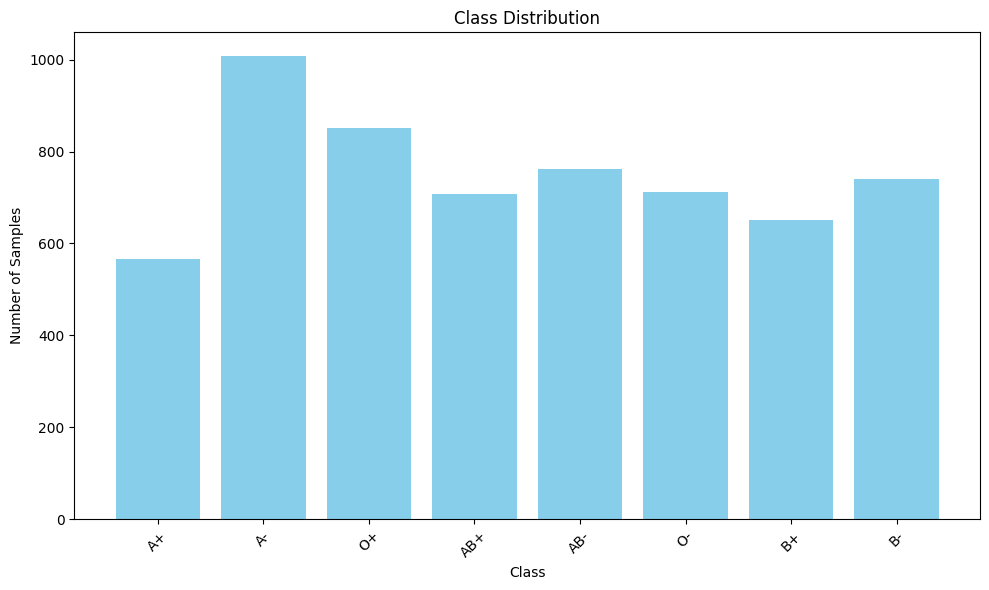

In [65]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    # Extract class names and their corresponding counts
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(class_names, class_counts)


In [66]:
#we need ro balance the dataset,so perform undersampling or oversampling

In [67]:
max_count=max(class_counts.values())

In [68]:
# performing oversampling
def oversample_class(class_id,count,max_count):

    #ensure the dataset is unbatched for filtering
    unbatched_dataset=dataset.unbatch()

    #filter the dataset for the specific class
    class_dataset=unbatched_dataset.filter(lambda img,lbl: tf.equal(lbl,class_id))

    #calculate the number of repetitions needed
    repeat_factor=max_count//count+(max_count%count>0)

    #repeat the dataset to match desired count
    return class_dataset.repeat(repeat_factor).take(max_count)
    

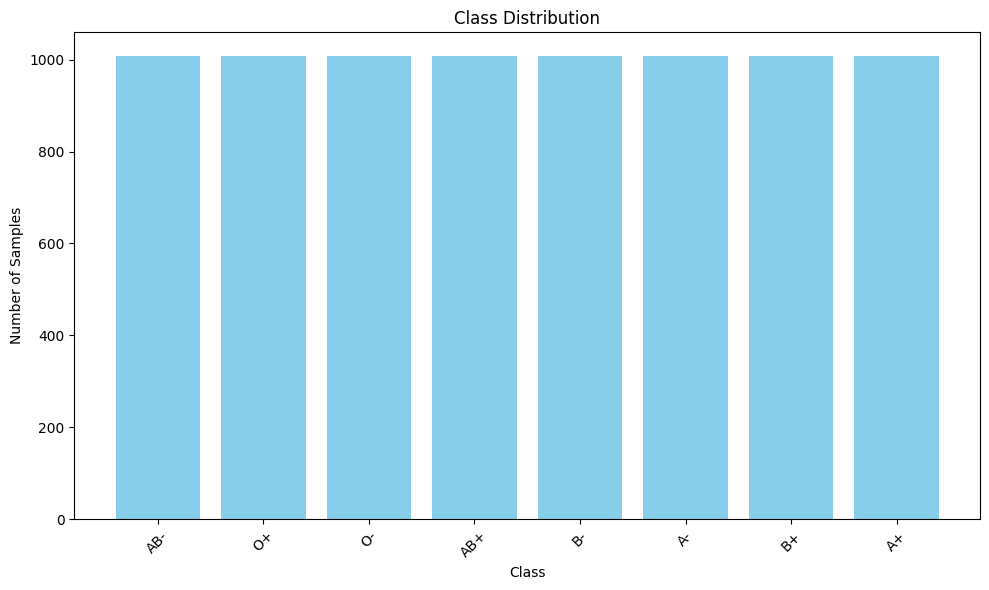

In [69]:
#step 1: balance the dataset

balanced_datasets=[]
for class_id,count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id,count,max_count))

#step 2: combine the balanced datasets
balanced_dataset=tf.data.Dataset.sample_from_datasets(balanced_datasets)

#step 3: check the balanced class distribution
balanced_class_counts=Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names,balanced_class_counts)

#step 4 : batch the balanced datasets
balanced_dataset=balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [70]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [71]:
balanced_dataset_unbatched=balanced_dataset.unbatch()
dataset_size=sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [72]:
# balacing of the dataset is done, now we need to divide the dataset into training and testing part, validation part

In [73]:
train_ratio=0.7
val_ratio=0.2

In [74]:
#unvatch the dataset to work at the sample level
balanced_dataset_unbatched=balanced_dataset.unbatch()

#compute the dataset based on dataset size and desired splits
train_size=int(train_ratio*dataset_size)
val_size=int(val_ratio*dataset_size)

#split the dataset into training, validation, and test
train_dataset=balanced_dataset_unbatched.take(train_size)
val_test_dataset=balanced_dataset_unbatched.skip(train_size)
val_dataset=val_test_dataset.take(val_size)
test_dataset=val_test_dataset.skip(val_size)

#rebatch the datasets after splitting
train_dataset=train_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset=val_dataset.batch(BATCH_SIZE,drop_remainder=True)
test_dataset=test_dataset.batch(BATCH_SIZE,drop_remainder=True)

#check the number of batches in each dataset
train_batch_count=sum(1 for _ in train_dataset)
val_batch_count=sum(1 for _ in val_dataset)
test_batch_count=sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")

Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [75]:
def create_high_accuracy_model():
    model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(64,64,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names),activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [76]:
#create a model
high_acc_model=create_high_accuracy_model()

In [77]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

#define ReduceLROnPlateau callback to reduce learning when validation loss plateaus
reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',  #monitor the validation loss
    factor=0.5,          #reduce the learning rate by the factor of 0.5
    patience=3,          # wait for 3 epochs without improvement before reducing LR
    verbose=1,           # print msg when LR is reduced
    min_lr=1e-6          # min learning rate to avoid too small values
)

#define EarlyStopping callback to stop training when validation loass does not improve
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True   #restore the model weights from the best epoch
)

In [78]:
#train the model
history_high_acc=high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr,early_stop]
)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 420ms/step - accuracy: 0.1310 - loss: 28.4047 - val_accuracy: 0.1256 - val_loss: 2.0394 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 421ms/step - accuracy: 0.1858 - loss: 2.0377 - val_accuracy: 0.1256 - val_loss: 2.0613 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 75s 424ms/step - accuracy: 0.3194 - loss: 1.7528 - val_accuracy: 0.1550 - val_loss: 2.0406 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 471ms/step - accuracy: 0.4462 - loss: 1.4479 - val_accuracy: 0.2273 - val_loss: 1.8151 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 428ms/step - accuracy: 0.5547 - loss: 1.2047 - val_accuracy: 0.5000 - val_loss: 1.3399 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 414ms/step - accuracy: 0.6167 - loss: 1.0291 - val_accuracy: 0.3346 - val_loss: 1.7279 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 414ms/step - accuracy: 0.

In [79]:
#evaluate the model
high_acc_eval=high_acc_model.evaluate(val_dataset)
print(f"High Accuracy model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.8346 - loss: 0.5700
High Accuracy model - Loss: 0.5650771856307983, Accuracy: 0.8100489974021912


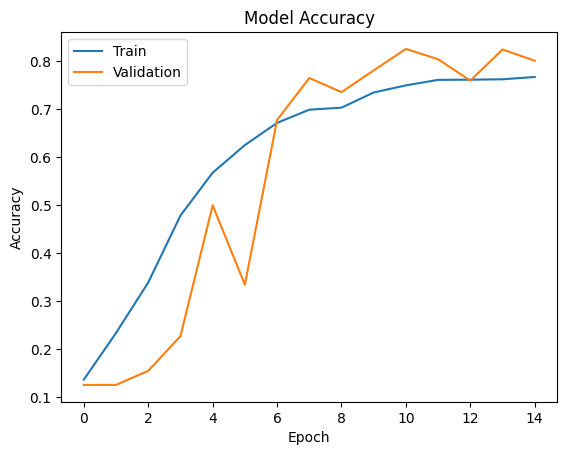

In [80]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Classification report:
              precision    

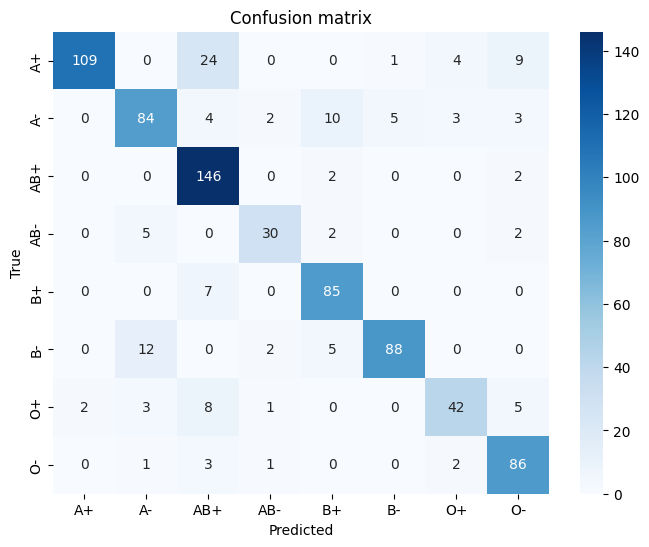

In [82]:
y_true=[]
y_pred=[]

for images,labels in test_dataset:
    predictions=high_acc_model.predict(images)
    predicted_labels=np.argmax(predictions,axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true=np.array(y_true)
y_pred=np.array(y_pred)

report=classification_report(y_true,y_pred,target_names=class_names)
print("Classification report:")
print(report)

conf_matrix=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [83]:
high_acc_model.save('model.h5')
print("model saved as HDF5 format")

model saved as HDF5 format
